#준비 작업

##라이브러리

In [1]:
import tensorflow as tf
from tensorflow import keras

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")

print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

Go to Runtime > Change runtime and select a GPU hardware accelerator.


In [2]:
import numpy as np
import os

랜덤 시드

In [3]:
seed = 21
np.random.seed(seed)
tf.random.set_seed(seed)

## matplot 세팅

In [4]:
#figure을 예쁘게
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14) #그래프 포함 틀(cf.figure ) axes)
mpl.rc('xtick', labelsize=12) #틱은 눈금을 의미
mpl.rc('ytick', labelsize=12)

In [5]:
#부드러운 애니메이션
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

## 코랩 세팅

In [6]:
!apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
!pip install -q -U tf-agents pyvirtualdisplay gym[atari,box2d]

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:15 http://ppa.launchpad.net/graphics-drive

##시뮬레이션 환경: OpenAI GYM Cartpole

In [7]:
import gym
gym.envs.registry.all() #gym 환경 나열

dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v3), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSp

In [8]:
env = gym.make('CartPole-v1') #gym 환경 가져오기

In [9]:
env.seed(seed)
obs = env.reset() #초기화

막대의 관성으로 막대의 방향이 바로 바뀌지 않는다

In [10]:
obs #관측값: 음수면 왼쪽 양수면 오른쪽으로 기울어여 있음

array([-0.00849164,  0.01960782,  0.04911291,  0.03888356])

In [11]:
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
    pass

In [12]:
env.render() #환경 출력: 이미지 파일

True

In [13]:
img = env.render(mode="rgb_array") #환경출력: numpy 배열
img.shape

(400, 600, 3)

##matplot으로 이미지 및 애니메이션 만들기

1. 이미지

In [14]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

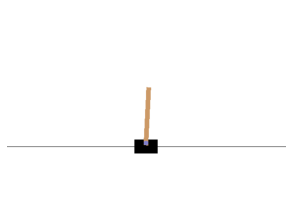

In [15]:
plot_environment(env)
plt.show()

2. 에니메이션

cartpole에 대한 한 episode를 실행하고 에니메이션을 위한 frames를 반환

In [16]:
def render_policy_net(model, n_max_steps=200, random_seed=seed):
    frames = []
    env = gym.make("CartPole-v1")
    env.seed(random_seed)
    np.random.seed(random_seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

render_policy_net 함수에서 반환받은 frames를 인자로 받아 애니메이션 출력

In [17]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

# 1. Simple hard Coding

막대가 왼쪽으로 기울어지면 카트를 왼쪽으로 가속하고, 오른쪽으로 기울어지면 오른쪽으로 가속한다. 에피소드를 500번 실행해서 얻은 평균 보상

In [18]:
# obs[2]의 각도를 보고 막대의 방향에 따라 카트의 방향 결정
# obs[2]를 보는 이유: 관성으로 인해 미리 적용이 필요
# 막대 왼쪽(-): 0 반환 / 오른쪽(+/0): 1 반환
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

episode: 100, step: 200

In [19]:
totals = []
for episode in range(100):
    episode_rewards = 0
    obs = env.reset()

    for step in range(200):
        action = basic_policy(obs) # 행동 결정

        obs, reward, done, info = env.step(action) # 행동을 플레이 하고 관측

        episode_rewards += reward # 보상

        if done: # done == true : episode 종료
            break
        
    totals.append(episode_rewards)

In [20]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(43.15, 9.227540300643504, 25.0, 71.0)

visualization

In [21]:
env.seed(seed)
frames = []

#한 에피소드에 대해
obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

In [22]:
plot_animation(frames)

#2. Policy Gradient

tf.GradientTape() : 자동 미분(주어진 입련 변수에 대한 연산의 그레디언트 계산)<br>
https://www.tensorflow.org/guide/autodiff?hl=kohttps://www.tensorflow.org/guide/autodiff?hl=ko

Reinforce 알고리즘

In [23]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis]) # obs[np.newaxis]: 축 추가 ex) [1, 2, 3, 4] -> [[1, 2, 3, 4]]
                                            # model에 obs를 넣어 left probability 예측
        action = (tf.random.uniform([1, 1]) > left_proba) # 1 - left_proba로 +면 true(1, 오른쪽), 아니면 false(0, 왼쪽)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32) # tf.cast(action, tf.float32): 불리언 값을 0(왼쪽) 또는 1(오른쪽)으로 변환
                                                                     # 왼쪽으로 이동할 티깃 확률 = 1 - action 값: 1(왼쪽), 0(오른쪽)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba)) # 손실함수 계산하고 손실 전체 원소의 평균

    grads = tape.gradient(loss, model.trainable_variables) # 손실 그레디언트 계산: 모델의 학습가능한 변수(하이퍼 파라미터)에 대한 손실의 도함수

    obs, reward, done, info = env.step(int(action[0, 0].numpy())) #행동을 플레이하고 관측

    return obs, reward, done, grads # 관측, 보상, 에피소드 종료 여부, 계산한 손실 그레디언트

In [24]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = [] # 모든 보상
    all_grads = []  # 모든 손실 그레디언트

    for episode in range(n_episodes):
        current_rewards = [] # 이번 에피소드의 보상
        current_grads = [] # 이번 에피소드의 손실 그레디언트

        obs = env.reset() # 초기화
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn) # 행동을 플레이 하고 관측

            current_rewards.append(reward) # 보상 저장
            current_grads.append(grads) # 손실 그레디언트 저장

            if done: # 에피소드가 끝났으면 끝내기
                break
            
        all_rewards.append(current_rewards) # 이번 에피소드에 대한 보상 저장
        all_grads.append(current_grads) # 이번 에피소드에 대한 손실 그레디언트 저장
    
    return all_rewards, all_grads

각 스텝에서 할인된 미래 보상의 합 계산

In [25]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards) # 한 에피소드이 모든 보상에 대해

    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor # 할인 계수를 이용하여 할인된 보상의 합(행동의 대가) 계산
    return discounted

여러 에피소드에 걸쳐 계산된 할인된 모든 보상(대가)에서 평균을 빼고 표준 편차를 나누어 정규화

In [26]:
def discount_and_normalize_rewards(all_rewards, discount_factor):
    # 각 에피소드에 대한 미래 보상의 합(대가)을 계산하여 대입
    all_discounted_rewards = [discount_rewards(rewards, discount_factor) for rewards in all_rewards]

    flat_rewards = np.concatenate(all_discounted_rewards) # 모든 에피소드에 대한 미래 보상의 합(대가)를 행 방향으로 합치기
    reward_mean = flat_rewards.mean() # 평균
    reward_std = flat_rewards.std() # 표준 편차

    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards] # 정규화: (각 에피소드의 대가 - 평균)/표준편차

In [27]:
discount_rewards([10, 0, -50], discount_factor=0.8)

array([-22, -40, -50])

In [28]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_factor=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

학습 세팅

In [29]:
n_iterations = 150 # 훈련 반복
n_episodes_per_update = 10 # 에피소드
n_max_steps = 200 # 스텝
discount_factor = 0.95 # 할인 계수

In [30]:
optimizer = keras.optimizers.Adam(lr=0.01) # 학습률이 0.1인 Adam 옵티마이저
loss_fn = keras.losses.binary_crossentropy # (왼쪽 또는 오른쪽) 이진 크로스 엔트로피 손실 함수

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


모델

In [31]:
keras.backend.clear_session() # 세션 종료
np.random.seed(seed)
tf.random.set_seed(seed)

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[4]), # FC layer( input shape: [4], output 차원: 5, 활성 함수: elu )
    keras.layers.Dense(1, activation="sigmoid"), # FC layer( ouput 차원: 1, 활성 함수: sigmoid)
])

학습

In [32]:
env.seed(seed);

for iteration in range(n_iterations):
    # 10(n_episodes_per_update)번 플레이를 하고 보상과 손실 그레디언트를 반환
    all_rewards, all_grads = play_multiple_episodes(env, n_episodes_per_update, n_max_steps, model, loss_fn)
    
    # 한 iteratino에 대한 결과
    total_rewards = sum(map(sum, all_rewards)) # 이번 iteration에 대한 모든 보상의 합
    print("\rIteration: {}, mean rewards: {:.1f}".format(iteration, total_rewards / n_episodes_per_update), end="") # iteration 번호, 보상의 평균

    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor) # 이번 iteratino의 보상을 정규화

    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)): # 훈련 가능한 변수(파라미터)에 대해
        mean_grads = tf.reduce_mean( # 정규화된 보상을 가중치 삼아 가중 평균을 구한다
            [final_reward * all_grads[episode_index][step][var_index] #정규화된 보상 * 그레디언트[에피소드 번호][스텝][파라미터 번호]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    
    # 평균 그레디언트로 파라미터 갱신(옵티마이저 적용)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()

Iteration: 149, mean rewards: 187.0

애니메이션

In [33]:
frames = render_policy_net(model)
plot_animation(frames)

#3. DQN

모델

In [34]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

input_shape = [4] # env의 관측(observation)의 차원: env.observation_space.shape
n_outputs = 2 # # env의 행동(action)의 차원: env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

epsilon-그리디 정책

In [35]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon: # 난수가 epsilon보다 작으면
        return np.random.randint(n_outputs) # epilon 확률로 랜덤하게 행동: 탐험
    else:
        Q_values = model.predict(state[np.newaxis]) # 모든 Q값을 예측해서
        return np.argmax(Q_values[0]) # 1- epsilon 확률로 그 순간 가장 최선인 것(가장 높은 Q 값)으로 행동: 활용

재생 메모리(replay memort) 또는 재생 버퍼(replay buffor)에 모든 경험 저장하고 훈련 반복 마다 여기에 랜덤한 훈련 배치를 샘플링

In [36]:
from collections import deque

replay_memory = deque(maxlen=2000)

재생 버퍼에서 경험을 랜덤하게 샘플링

In [37]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices] # 재생 버퍼에서 경험을 랜덤하게 가져오기

    # 경험에 대해 현재 상태, 행동, 보상, 다음 상태, 에피소드 종료 여부에 상응하는 넘파이 배열 5개
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]

    return states, actions, rewards, next_states, dones

In [38]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon) # epsilon-그리디 정책으로 탐험과 활용 선택

    next_state, reward, done, info = env.step(action) # 행동을 플레이 하고 관측

    replay_memory.append((state, action, reward, next_state, done)) # 경험을 재생 버퍼에 저장
    
    return next_state, reward, done, info

DQN

In [39]:
batch_size = 32
discount_factor = 0.95

optimizer = keras.optimizers.Adam(lr=1e-2) # Adam 옵티마이저
loss_fn = keras.losses.mean_squared_error # MSE 손실 함수

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


tf.GradientTape() : 자동 미분(주어진 입련 변수에 대한 연산의 그레디언트 계산)<br>
https://www.tensorflow.org/guide/autodiff?hl=kohttps://www.tensorflow.org/guide/autodiff?hl=ko

In [40]:
def training_step(batch_size):
    experiences = sample_experiences(batch_size) #재생 버퍼에서 랜덤 샘플링에 대한
    states, actions, rewards, next_states, dones = experiences # 상태, 행동, 보상, 다음 상태, 에피소드 종료 여부

    next_Q_values = model.predict(next_states) # 다음 상태에서 가능한 모든 행동에 대한 Q-가치
    max_next_Q_values = np.max(next_Q_values, axis=1) # 다음 상태에서 최대 Q-가치
    target_Q_values = (rewards + # 타깃 Q-가치 = 즉각적 보상 + 최적으로 행동해서 얻은 할인된 가치를 더한 미래 보상
                       (1 - dones) * discount_factor * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1) # 차원의 재구조화: -1 = 원래 길이와 남은 차원으로 부터 추정
    mask = tf.one_hot(actions, n_outputs) # One-hot 인코딩: action이 대상, n_ouput은 깊이

    with tf.GradientTape() as tape:
        all_Q_values = model(states) # 모든 Q-가치 예측
        # mask와 모든 Q-가치를 곱하여 원하지 않은 Q_가치를 0으로 만든다
        # 그다음 0을 없애기 위해 열 방향(axis=1)으로 덧셈하여 예측하려는 (s, a)쌍만 남긴다
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values)) # 경험한 (s, a)쌍에 대한 티깃과 예측한 Q값 사이의 손실(MSE)
    
    grads = tape.gradient(loss, model.trainable_variables) # 손실 그레디언트 계산: 모델의 학습가능한 변수(하이퍼 파라미터)에 대한 손실의 도함수
    optimizer.apply_gradients(zip(grads, model.trainable_variables)) # 손실 그레디언트로 파라미터 갱신(옵티마이저 적용)

학습

In [41]:
env.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

rewards = [] 
best_score = 0

최대 스텝 200번으로 이뤄진 에피소드 600개 실행

In [42]:
for episode in range(600):
    obs = env.reset() # 초기화

    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01) # epsilon 계산: 500번 에피소드 직전까지 1에서 0.01로 선형적으로 줄어든다
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") # 에피소드 번호, 스텝, epsilon

    # 훈련 없이 에피소드 50번 플레이: 재생 버퍼가 충분히채워질 시간 주기 위해
    # 50번 이후 부터는 훈련: 파라미터 갱신
    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights) # 가중치 적용

Episode: 599, Steps: 200, eps: 0.010

각 에피소드애서 에이전트가 얻은 총 보상

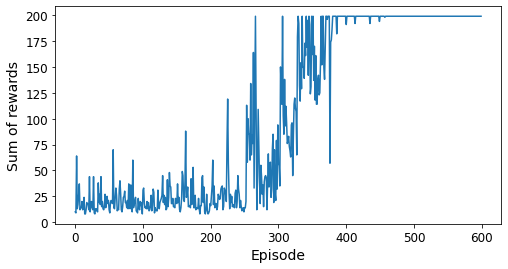

In [43]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

애니메이션

In [44]:
env.seed(seed)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

#4. Double DQN

In [46]:
keras.backend.clear_session()
tf.random.set_seed(seed)
np.random.seed(seed)

input_shape = [4] # env의 관측(observation)의 차원: env.observation_space.shape
n_outputs = 2 # env의 행동(action)의 차원: env.action_space.n

model = keras.models.Sequential([ # 온라인 모델(Q-네트워크, Q-함수)
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

target = keras.models.clone_model(model) # 타깃 모델(타깃 Q-네트워크, 타깃 Q-함수): 온라인 모델 복제해서 타깃 모델에 대입
target.set_weights(model.get_weights()) # 온라인 모델의 가중치 복제해서 타깃 모델에 대입

앞선 DQN에서 최선의 행동에 대한 Q-가치 추정할때 타깃 모델 사용

In [47]:
batch_size = 32
discount_factor = 0.95
optimizer = keras.optimizers.Adam(lr=6e-3)
loss_fn = keras.losses.Huber()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [48]:
def training_step(batch_size):
    experiences = sample_experiences(batch_size) #재생 버퍼에서 랜덤 샘플링에 대한
    states, actions, rewards, next_states, dones = experiences # 상태, 행동, 보상, 다음 상태, 에피소드 종료 여부
    
    next_Q_values = model.predict(next_states) # 다음 상태에서 가능한 모든 행동에 대한 Q-가치
    best_next_actions = np.argmax(next_Q_values, axis=1) # 다음 상태에서 최대 Q-가치
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy() # One-hot 인코딩: action이 대상, n_ouput은 깊이

    # 타깃 모델로 Q-가치 추정
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1) # 다음 상태에서 가능한 행동 중 예측하려는 (s, a)쌍에 대한 Q-가치
    target_Q_values = (rewards +   # 타깃 Q-가치 = 즉각적 보상 + 최적으로 행동해서 얻은 할인된 가치를 더한 미래 보상
                       (1 - dones) * discount_factor * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1) # 차원의 재구조화: -1 = 원래 길이와 남은 차원으로 부터 추정

    mask = tf.one_hot(actions, n_outputs) # One-hot 인코딩: action이 대상, n_ouput은 깊이

    with tf.GradientTape() as tape:
        all_Q_values = model(states) # 모든 Q 가치 에측
        # mask와 모든 Q-가치를 곱하여 원하지 않은 Q_가치를 0으로 만든다
        # 그다음 0을 없애기 위해 열 방향(axis=1)으로 덧셈하여 예측하려는 (s, a)쌍만 남긴다
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values)) # 경험한 (s, a)쌍에 대한 티깃과 예측한 Q값 사이의 손실(MSE)
    
    grads = tape.gradient(loss, model.trainable_variables) # 손실 그레디언트 계산: 모델의 학습가능한 변수(하이퍼 파라미터)에 대한 손실의 도함수
    optimizer.apply_gradients(zip(grads, model.trainable_variables)) # 손실 그레디언트로 파라미터 갱신(옵티마이저 적용)

리플레이 메모리(리플레이 버퍼, 재생 메모리, 재생 버퍼)

In [49]:
replay_memory = deque(maxlen=2000)

학습

In [50]:
env.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

rewards = []
best_score = 0

최대 스텝 200번으로 이뤄진 에피소드 600개 실행

In [51]:
for episode in range(600):
    obs = env.reset() # 초기화

    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01) # epsilon 계산: 500번 에피소드 직전까지 1에서 0.01로 선형적으로 줄어든다
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") # 에피소드 번호, 스텝, epsilon

    # 훈련 없이 에피소드 50번 플레이: 재생 버퍼가 충분히채워질 시간 주기 위해
    # 50번 이후 부터는 훈련: 파라미터 갱신
    if episode >= 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())

    # 또는 각 스텝마다 soft updates
    #if episode >= 50:
        #target_weights = target.get_weights()
        #online_weights = model.get_weights()
        #for index in range(len(target_weights)):
        #    target_weights[index] = 0.99 * target_weights[index] + 0.01 * online_weights[index]
        #target.set_weights(target_weights)

model.set_weights(best_weights) # 가중치 적용

Episode: 599, Steps: 29, eps: 0.010

각 에피소드에서 에이전트가 얻은 총 보상

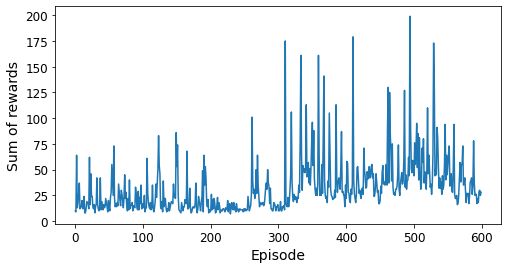

In [52]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

애니메이션

In [53]:
env.seed(seed)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
   
plot_animation(frames)

#5. Dueling Double DQN

In [54]:
keras.backend.clear_session()
tf.random.set_seed(seed)
np.random.seed(seed)

함수형 API로 구형한 간단한 듀얼링 API

keras.backend: 특수하고 잘 최적화 된 텐서 라이브러리<br>
https://keras.io/ko/backend/#_1 <br>
keras.backend.max(x, axis=None, keepdims=False): 텐서에서 최대값 반환 <br>
x: 텐서나 변수<br>
axis: 최대값을 찾을 축의 개수(None이면 전체 차원 축)<br>
keepdim: 차원을 유지할 것인지(False이면 차원이 1로 줄어든다)

In [55]:
K = keras.backend

input_states = keras.layers.Input(shape=[4])
hidden1 = keras.layers.Dense(32, activation="elu")(input_states)
hidden2 = keras.layers.Dense(32, activation="elu")(hidden1)

# V(s): 상태 s의 가치 == 상태 s에서 최선의 행동 a*의 Q-가치(최적의 정책은 최선의 행동을 선택한다고 가정하기 때문)
# V(s) = Q(s, a*)
# 이므로 A(s, a*) = 0 **** (1)
state_values = keras.layers.Dense(1)(hidden2)

# A(s, a): 상태 s에서 다른 모든 가능한 행동과 비교하여 행동 a를 선택했을 때 이득
# 듀얼링 DQN에서는 모델이 상태의 가치와 가능한 모든 행동의 이익을 모두 추정한다
# (1)에 의해 최선의 행동 a*의 이익은 0이기 때문에 모델이
# 모델이 예측한 모든 이익 raw_davantage에서 모든 최대 이익을 뺸다
raw_advantages = keras.layers.Dense(n_outputs)(hidden2)
advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims=True) 

# Q-가치: Q(s, a) = V(s) + A(s, a) = 상태 s의 가치 + 상태 s에서 다른 모든 가능한 행동과 비교해서 행동 a를 선택했을 때 이득
Q_values = state_values + advantages

# 온라인 모델(Q-네트워크, Q-함수)
model = keras.models.Model(inputs=[input_states], outputs=[Q_values])

# 타깃 모델(타깃 Q-네트워크, 타깃 Q-함수)
target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

앞선 DQN에서 최선의 행동에 대한 Q-가치 추정할때 타깃 모델 사용

In [56]:
batch_size = 32
discount_factor = 0.95
optimizer = keras.optimizers.Adam(lr=7.5e-3)
loss_fn = keras.losses.Huber()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [57]:
def training_step(batch_size):
    experiences = sample_experiences(batch_size) #재생 버퍼에서 랜덤 샘플링에 대한
    states, actions, rewards, next_states, dones = experiences # 상태, 행동, 보상, 다음 상태, 에피소드 종료 여부
    
    next_Q_values = model.predict(next_states) # 다음 상태에서 가능한 모든 행동에 대한 Q-가치
    best_next_actions = np.argmax(next_Q_values, axis=1) # 다음 상태에서 최대 Q-가치
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy() # One-hot 인코딩: action이 대상, n_ouput은 깊이

    # 타깃 모델로 Q-가치 추정
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1) # 다음 상태에서 가능한 행동 중 예측하려는 (s, a)쌍에 대한 Q-가치
    target_Q_values = (rewards +   # 타깃 Q-가치 = 즉각적 보상 + 최적으로 행동해서 얻은 할인된 가치를 더한 미래 보상
                       (1 - dones) * discount_factor * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1) # 차원의 재구조화: -1 = 원래 길이와 남은 차원으로 부터 추정

    mask = tf.one_hot(actions, n_outputs) # One-hot 인코딩: action이 대상, n_ouput은 깊이

    with tf.GradientTape() as tape:
        all_Q_values = model(states) # 모든 Q 가치 에측
        # mask와 모든 Q-가치를 곱하여 원하지 않은 Q_가치를 0으로 만든다
        # 그다음 0을 없애기 위해 열 방향(axis=1)으로 덧셈하여 예측하려는 (s, a)쌍만 남긴다
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values)) # 경험한 (s, a)쌍에 대한 티깃과 예측한 Q값 사이의 손실(MSE)
    
    grads = tape.gradient(loss, model.trainable_variables) # 손실 그레디언트 계산: 모델의 학습가능한 변수(하이퍼 파라미터)에 대한 손실의 도함수
    optimizer.apply_gradients(zip(grads, model.trainable_variables)) # 손실 그레디언트로 파라미터 갱신(옵티마이저 적용)

리플레이 메모리(리플레이 버퍼, 재생 메모리, 재생 버퍼)

In [58]:
replay_memory = deque(maxlen=2000)

학습

In [59]:
env.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

rewards = []
best_score = 0

최대 스텝 200번으로 이뤄진 에피소드 600개 실행

In [60]:
for episode in range(600):
    obs = env.reset() # 초기화

    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01) # epsilon 계산: 500번 에피소드 직전까지 1에서 0.01로 선형적으로 줄어든다
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") # 에피소드 번호, 스텝, epsilon

    # 훈련 없이 에피소드 50번 플레이: 재생 버퍼가 충분히채워질 시간 주기 위해
    # 50번 이후 부터는 훈련: 파라미터 갱신
    if episode >= 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())

    # 또는 각 스텝마다 soft updates
    #if episode >= 50:
        #target_weights = target.get_weights()
        #online_weights = model.get_weights()
        #for index in range(len(target_weights)):
        #    target_weights[index] = 0.99 * target_weights[index] + 0.01 * online_weights[index]
        #target.set_weights(target_weights)

model.set_weights(best_weights) # 가중치 적용

Episode: 599, Steps: 38, eps: 0.010

각 에피소드에서 에이전트가 얻은 총 보상

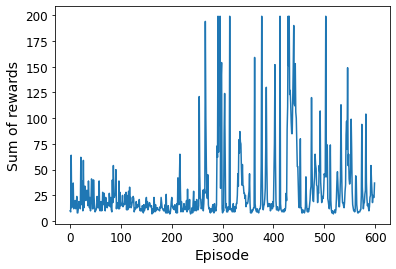

In [61]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Sum of rewards")
plt.show()

애니메이션

In [62]:
env.seed(seed)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

# 시뮬레이션 환경 끝내기

In [63]:
env.close()